#  __train.csv:__ A full training dataset with the following attributes: 

### __id:__ unique id for a news article

### __title:__ the title of a news article

###__author:__ author of the news article

###__text:__ the text of the article; could be incomplete

###__label:__ a label that marks the article as potentially unreliable

###__1: unreliable or Fake__

###__0: reliable or True__ 

In [ ]:
import numpy as np       
import pandas as pd       
import matplotlib.pyplot as plt   # for data visualisation
import itertools
import re   # for string operations

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# hyperparameter tuning 
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split    # train test split
# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
# transforming text into numerical format
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 5.7 MB/s 


In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset link:  https://www.kaggle.com/competitions/fake-news/data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# checking null values
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df1 = df.copy()
df1 = df1.dropna().reset_index(drop=True)       # dropping null values
df1.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
df1.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# Checking for duplicate values
len(df1[df1.duplicated()])

0

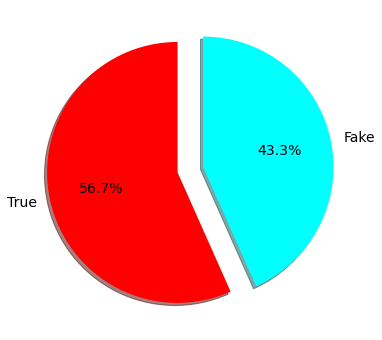

In [ ]:
# Checking if our data is well balanced
plt.figure(figsize=(9,6))
plt.pie(df1['label'].value_counts(),explode=[0.1,0.1],colors=['red','cyan'],startangle=90,shadow=True,labels=['True','Fake'],autopct='%1.1f%%',textprops={'fontsize': 14});

In [ ]:
# removing the commoner inflexional endings from words in English
import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words('english')
text_cleaning_re = '[^a-zA-Z]'

In [ ]:
# function for text processing
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()     # use re package to removing everything that is not in letter
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
# text processing
df1['text'] = df1['text'].apply(lambda x: preprocess(x))
df1['text'].head()

0    house dem aide even see comey letter jason cha...
1    ever get feeling life circles roundabout rathe...
2    truth might get fired october tension intellig...
3    videos civilians killed single us airstrike id...
4    print iranian woman sentenced six years prison...
Name: text, dtype: object

In [ ]:
X = df1.text.values           # independent variable
y = df1.label.values          # dependent variable

In [ ]:
# splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 79)

In [ ]:
# transform our textual X to numerical so that our ML model can understand it and can work with it
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_features=5000,ngram_range=(1,3),max_df=0.7)

tfidf_train = tfidf_v.fit_transform(X_train).toarray()
tfidf_test = tfidf_v.transform(X_test).toarray()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# <b> RandomForest Classifier </b>

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=50, min_samples_leaf=46, random_state=8)
rf_clf.fit(tfidf_train,y_train)
tr_preds = rf_clf.predict(tfidf_train)  # predicting train
preds = rf_clf.predict(tfidf_test)      # predicting test

In [ ]:
print('Train accuracy:',accuracy_score(y_train, tr_preds))
print('Test accuracy:',accuracy_score(y_test, preds))

Train accuracy: 0.8997812414547444
Test accuracy: 0.8900738310090238


In [ ]:
# train classification report for RandomForest
print(classification_report(y_train,tr_preds))

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      8289
           1       0.94      0.82      0.88      6339

    accuracy                           0.90     14628
   macro avg       0.91      0.89      0.90     14628
weighted avg       0.90      0.90      0.90     14628



In [ ]:
# test classification report for RandomForest
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2072
           1       0.93      0.80      0.86      1585

    accuracy                           0.89      3657
   macro avg       0.90      0.88      0.89      3657
weighted avg       0.89      0.89      0.89      3657



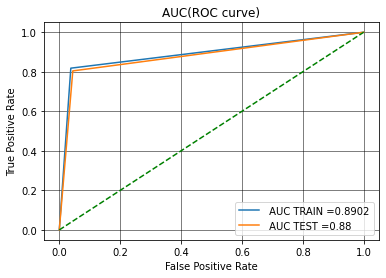

In [ ]:
# train and test ROC-AUC curve for RandomForest

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, tr_preds)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr).round(4)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr).round(4)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Confusion matrix, without normalization


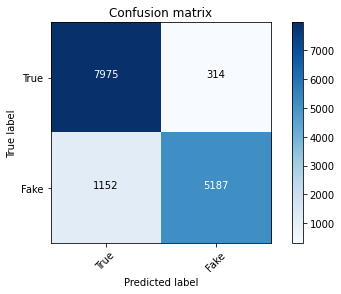

In [ ]:
# train confusion matrix for RandomForest
cm_train = confusion_matrix(y_train,tr_preds)
plot_confusion_matrix(cm_train,classes=['True','Fake'])

Confusion matrix, without normalization


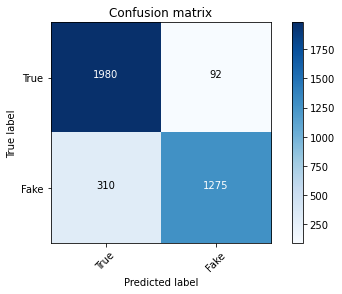

In [ ]:
# test confusion matrix for RandomForest
cm_test = confusion_matrix(y_test,preds)
plot_confusion_matrix(cm_test,classes=['True','Fake'])

# <b> Logistic Regression </b>

In [ ]:
lr = LogisticRegression(C=2, max_iter=10000)
lr.fit(tfidf_train,y_train)
tr_preds = lr.predict(tfidf_train)
preds = lr.predict(tfidf_test)

In [ ]:
print('Train accuracy:',accuracy_score(y_train, tr_preds))
print('Test accuracy:',accuracy_score(y_test, preds))

Train accuracy: 0.9793546622914958
Test accuracy: 0.9526934645884605


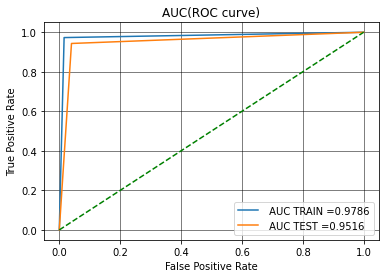

In [ ]:
# train and test ROC-AUC curve for Logistic Regression
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, tr_preds)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, preds)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr).round(4)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr).round(4)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Confusion matrix, without normalization


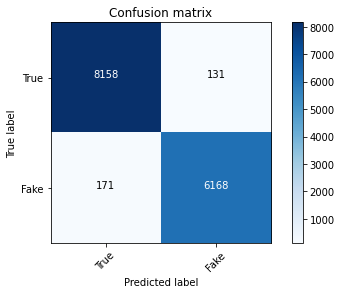

In [ ]:
# train confusion matrix for Logistic Regession
cm_train = confusion_matrix(y_train,tr_preds)
plot_confusion_matrix(cm_train,classes=['True','Fake'])

Confusion matrix, without normalization


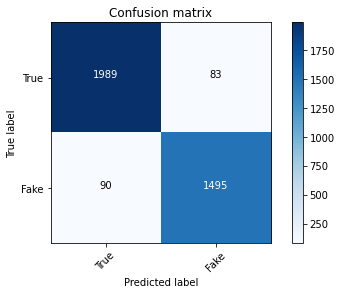

In [ ]:
# test confusion matrix for Logistic Regession
cm_test = confusion_matrix(y_test,preds)
plot_confusion_matrix(cm_test,classes=['True','Fake'])

# <b> Testing on different datasets </b>

In [ ]:
# Dataset link:  https://drive.google.com/file/d/1er9NJTLUA3qnRuyhfzuN0XUsoIC4a-_q/view
# Different dataset for testing
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/news.csv')
test.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# encoding the target variable into numerical format
encoder = {'label': {'FAKE':1, 'REAL':0}}
t1 = test.copy()
t1 = t1.replace(encoder)

In [ ]:
t1.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0


In [ ]:
t1['text'] = t1['text'].apply(lambda x: preprocess(x))    # text processing
t1['text'].head()

0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
2    u secretary state john f kerry said monday sto...
3    kaydee king kaydeeking november lesson tonight...
4    primary day new york front runners hillary cli...
Name: text, dtype: object

In [ ]:
X1 = t1.text.values
X1_tfidf = tfidf_v.transform(X1).toarray()
t1['label_rf'] = rf_clf.predict(X1_tfidf)

In [ ]:
accuracy_score(t1.label,t1.label_rf)    # RandomForest model

0.7602209944751381

In [ ]:
print(classification_report(t1.label,t1.label_rf))    # RandomForest model

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      3171
           1       0.74      0.79      0.77      3164

    accuracy                           0.76      6335
   macro avg       0.76      0.76      0.76      6335
weighted avg       0.76      0.76      0.76      6335



Confusion matrix, without normalization


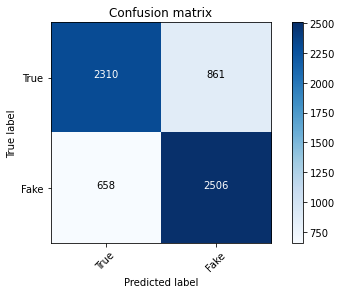

In [ ]:
cm1_rf = confusion_matrix(t1.label,t1.label_rf)       # RandomForest model
plot_confusion_matrix(cm1_rf,classes=['True','Fake'])

In [ ]:
t1['label_lr'] = lr.predict(X1_tfidf)

In [ ]:
accuracy_score(t1.label,t1.label_lr)      # Logistic Regression model

0.7829518547750592

In [ ]:
print(classification_report(t1.label,t1.label_lr))    # Logistic Regression model

              precision    recall  f1-score   support

           0       0.93      0.61      0.74      3171
           1       0.71      0.95      0.81      3164

    accuracy                           0.78      6335
   macro avg       0.82      0.78      0.78      6335
weighted avg       0.82      0.78      0.78      6335



Confusion matrix, without normalization


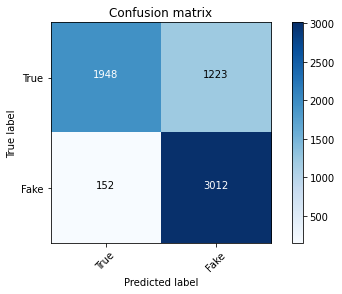

In [ ]:
cm1_lr = confusion_matrix(t1.label,t1.label_lr)     # Logistic Regression model
plot_confusion_matrix(cm1_lr,classes=['True','Fake'])

In [ ]:
# Dataset link:  https://www.kaggle.com/datasets/mohamadalhasan/a-fake-news-dataset-around-the-syrian-war
t2 = pd.read_csv('/content/fake_news.csv',encoding='latin')
t2.head() # 0 means FAKE news and 1 means TRUE news in this this dataset

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [ ]:
# creating new target variable so that FAKE news are represented by 1 and TRUE news by 0
t2['new_label'] = t2['labels'].apply(lambda x: 1 if x==0 else 0)

In [ ]:
t2['article_content'] = t2['article_content'].apply(lambda x: preprocess(x))      # text processing
t2['article_content'].head()

0    wed apr syria attack symptoms consistent nerve...
1    fri apr homs governor says u attack caused dea...
2    sun apr death toll aleppo bomb attack least de...
3    wed apr aleppo bomb blast kills six syrian sta...
4    sun jul syria rebels dead fighting key aleppo ...
Name: article_content, dtype: object

In [ ]:
X2 = t2.article_content.values
X2_tfidf = tfidf_v.transform(X2).toarray()
t2['label_rf'] = rf_clf.predict(X2_tfidf)
t2.head()

,unit_id,article_title,article_content,source,date,location,labels,new_label,label_rf
0,1914947530,Syria attack symptoms consistent with nerve ag...,wed apr syria attack symptoms consistent nerve...,nna,4/5/2017,idlib,0,1,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,fri apr homs governor says u attack caused dea...,nna,4/7/2017,homs,0,1,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,sun apr death toll aleppo bomb attack least de...,nna,4/16/2017,aleppo,0,1,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,wed apr aleppo bomb blast kills six syrian sta...,nna,4/19/2017,aleppo,0,1,1
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,sun jul syria rebels dead fighting key aleppo ...,nna,7/10/2016,aleppo,0,1,0


In [ ]:
accuracy_score(t2.new_label,t2.label_rf)      # RandomForest model

0.503731343283582

In [ ]:
print(classification_report(t2.new_label,t2.label_rf))      # RandomForest model

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       426
           1       0.46      0.37      0.41       378

    accuracy                           0.50       804
   macro avg       0.50      0.50      0.49       804
weighted avg       0.50      0.50      0.50       804



In [ ]:
t2['label_lr'] = lr.predict(X2_tfidf)

In [ ]:
accuracy_score(t2.new_label,t2.label_lr)      # Logistic Regression model

0.4900497512437811

In [ ]:
print(classification_report(t2.new_label,t2.label_lr))      # Logistic Regression model

              precision    recall  f1-score   support

           0       0.53      0.36      0.43       426
           1       0.47      0.63      0.54       378

    accuracy                           0.49       804
   macro avg       0.50      0.50      0.48       804
weighted avg       0.50      0.49      0.48       804



In [ ]:
# Dataset link:  https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
fake_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/Fake News Detection/True.csv')

In [ ]:
# creating labels
fake_news['label'] = 1
true_news['label'] = 0

In [ ]:
# Mixing fake and true datasets
news_df = pd.concat([true_news,fake_news])
news_df = news_df.sample(frac=1, random_state=8).reset_index(drop=True)

In [ ]:
news_df.head()

,title,text,subject,date,label
0,Trump Just Demanded The New York Times APOLOG...,Donald Trump s slow and visibly painful meltdo...,News,"February 16, 2017",1
1,WIKILEAKS HITS BACK At Lying Political Hack Ja...,,Government News,"Jan 5, 2017",1
2,Oil drilling advocate to be Trump pick for Int...,WASHINGTON (Reuters) - U.S. President-elect Do...,politicsNews,"December 9, 2016",0
3,Australia okays use of China drones in non-cla...,MELBOURNE (Reuters) - The Australian governmen...,worldnews,"September 22, 2017",0
4,Top ranks of career U.S. diplomats thin under ...,WASHINGTON (Reuters) - The U.S. foreign servic...,politicsNews,"November 8, 2017",0


In [ ]:
news_df['text'] = news_df['text'].apply(lambda x: preprocess(x))        # text processing
news_df['text'].head()

0    donald trump slow visibly painful meltdown adm...
1                                                     
2    washington reuters u president elect donald tr...
3    melbourne reuters australian government resume...
4    washington reuters u foreign service seen top ...
Name: text, dtype: object

In [ ]:
X3 = news_df.text.values
X3_tfidf = tfidf_v.transform(X3).toarray()
news_df['label_rf'] = rf_clf.predict(X3_tfidf)
news_df.head()

,title,text,subject,date,label,label_rf
0,Trump Just Demanded The New York Times APOLOG...,donald trump slow visibly painful meltdown adm...,News,"February 16, 2017",1,0
1,WIKILEAKS HITS BACK At Lying Political Hack Ja...,,Government News,"Jan 5, 2017",1,1
2,Oil drilling advocate to be Trump pick for Int...,washington reuters u president elect donald tr...,politicsNews,"December 9, 2016",0,0
3,Australia okays use of China drones in non-cla...,melbourne reuters australian government resume...,worldnews,"September 22, 2017",0,1
4,Top ranks of career U.S. diplomats thin under ...,washington reuters u foreign service seen top ...,politicsNews,"November 8, 2017",0,0


In [ ]:
accuracy_score(news_df.label,news_df.label_rf)      # RandomForest model

0.6996525457704129

In [ ]:
print(classification_report(news_df.label,news_df.label_rf))      # RandomForest model

              precision    recall  f1-score   support

           0       0.63      0.88      0.74     21417
           1       0.83      0.54      0.65     23481

    accuracy                           0.70     44898
   macro avg       0.73      0.71      0.69     44898
weighted avg       0.73      0.70      0.69     44898



Confusion matrix, without normalization


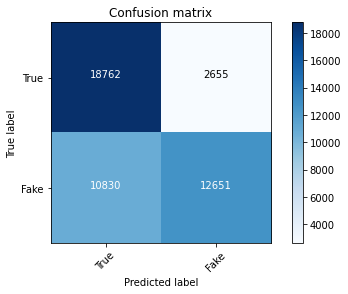

In [ ]:
cm3_rf = confusion_matrix(news_df.label,news_df.label_rf)       # RandomForest model
plot_confusion_matrix(cm3_rf,classes=['True','Fake'])

In [ ]:
news_df['label_lr'] = lr.predict(X3_tfidf)

In [ ]:
accuracy_score(news_df.label,news_df.label_lr)      # Logistic Regression model

0.7773620205799813

In [ ]:
print(classification_report(news_df.label,news_df.label_lr))      # Logistic Regression model

              precision    recall  f1-score   support

           0       0.73      0.84      0.78     21417
           1       0.83      0.72      0.77     23481

    accuracy                           0.78     44898
   macro avg       0.78      0.78      0.78     44898
weighted avg       0.78      0.78      0.78     44898



Confusion matrix, without normalization


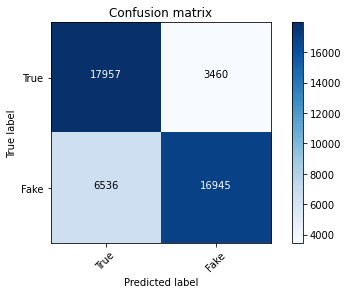

In [ ]:
cm3_lr = confusion_matrix(news_df.label,news_df.label_lr)       # Logistic Regression model
plot_confusion_matrix(cm3_lr,classes=['True','Fake'])